# Forecasting Retail Demand with Vertex AI and BQML 

## Table Of Contents
* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Explore Data](#section-5)
* [Modeling with BigQuery and the ARIMA model](#section-6)
* [Evaluating model](#section-7)
* [Executor](#section-8)
* [Clean Up](#section-9)



## Overview 
<a name="section-1"></a>


In this notebook, we explore demand forecasting using bigquery public retail dataset. Being able to measure and forecast customer demand can help retailers better understand their customers, stock shelves with the right products, offer targeted promotions, and generally, better plan and manage their budgets. We apply an ARIMA model (Autoregressive integrated moving average) from BQML on retail data. This notebook demonstrates how to train and evaluate a BQML model for demand forecasting datasets, extract actionable future insights.

You have to follow this steps before going through this notebook inside Vertex-AI notebook instance :
* Create a managed notebook instance in Vertex-AI with python3 ("NumPy/SciPy/scikit-learn") environment on a n1-standard4 instance.


#### ARIMA Modeling with BQML 

The <a href='https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average'>ARIMA model</a> is designed to analyze historical data, spot patterns over time, and project them into the future, i.e. forecasting. The model is available inside BigQuery ML and enables users to create and execute machine learning models directly in BigQuery using SQL queries. Working with BQML is advantageous, as it already has access to the data, it can handle most of the modeling details automatically if desired, and will store both the model and any predictions also inside BigQuery. 


## Dataset 
<a name="section-2"></a>

This notebook uses the bigquery public retail data set.
The data covers 10 US stores and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, gross_margin. 


## Objective
<a name="section-3"></a>
In this tutorial we follow below steps
* Explore Data
* Model with BigQuery and the ARIMA model
* Evaluate the model
* Evaluate the Model Results using BQML (on Training Data)
* Evalute the Model Results - MAE, MAPE, MSE, RMSE (on Test data)
* Executor feature

## Costs
<a name="section-4"></a>
This tutorial uses the following billable components of Google Cloud:

* Vertex AI
* Bigquery

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Bigquery
pricing](https://cloud.google.com/bigquery/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin

**Note:** This notebook does not require a GPU runtime.

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, Cloud Storage, and Compute Engine APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,storage-component.googleapis.com). 

1. Follow the "**Configuring your project**" instructions from the Vertex Pipelines documentation.

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [143]:
import os
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  vertex-ai-dev


Otherwise, set your project ID here.

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [144]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

## Import libraries and define constants

Load the required libraries

In [1]:
from functools import partial
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
from google.cloud.bigquery import Client, QueryJobConfig
import datetime
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [99]:
PROJECT_ID='vertex-ai-dev'
DATASET='demandforecasting'
SALES_TABLE='total_formatted_data'

Create a bigquery datatset

#@bigquery
CREATE SCHEMA demandforecasting
OPTIONS(
  location="us"
  )

## Explore the Data
<a name="section-5"></a>

Viewing the data

#@bigquery
SELECT * FROM `looker-private-demo.retail.transaction_detail`

Creating a view in which we will ve extracting the important fields and will be selecting store with id 10 

#@bigquery
CREATE OR REPLACE VIEW demandforecasting.important_fields AS
(
    SELECT transaction_timestamp,line_items from `looker-private-demo.retail.transaction_detail` WHERE store_id = 10
)   

Viewing the data

#@bigquery
SELECT * FROM demandforecasting.important_fields

Converting timestamp to date for transaction_timestamp column 

#@bigquery
CREATE OR REPLACE VIEW demandforecasting.data_after_converting_timestamp_to_date AS
(
    SELECT EXTRACT(DATE FROM transaction_timestamp AT TIME ZONE "UTC") AS date,line_items from demandforecasting.important_fields
)   

Viewing the data

#@bigquery
SELECT * FROM demandforecasting.data_after_converting_timestamp_to_date

In [145]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """SELECT * FROM demandforecasting.data_after_converting_timestamp_to_date"""
job = client.query(query)
df_intermediary = job.to_dataframe()

In [146]:
df_intermediary.dtypes

date          object
line_items    object
dtype: object

Line items is array of structs. We have to split each array into individual items



#@bigquery
CREATE OR REPLACE VIEW demandforecasting.split_array_of_structs AS
 
(SELECT date,line_items
FROM demandforecasting.data_after_converting_timestamp_to_date, UNNEST(line_items) AS line_items)

Viewing data

#@bigquery
SELECT * FROM demandforecasting.split_array_of_structs

We want only product_id column so ignoring other columns

#@bigquery
CREATE OR REPLACE VIEW demandforecasting.splitting_struct_columns AS
 
(SELECT date,line_items.product_id as product_id
FROM demandforecasting.split_array_of_structs)

Viewing data

#@bigquery
SELECT * FROM demandforecasting.splitting_struct_columns 

Here we are counting the sales of a product for each date

#@bigquery
CREATE OR REPLACE VIEW demandforecasting.sales_count_per_date AS
 
(SELECT date,product_id,COUNT(*) as sales_count
FROM demandforecasting.splitting_struct_columns GROUP BY date,product_id)

#@bigquery
SELECT * FROM demandforecasting.sales_count_per_date

Here we are creating a view for top five sold products. The products are chosen for which the sum of sales over all dates is highest

#@bigquery
CREATE OR REPLACE VIEW demandforecasting.top_five_products AS (
    WITH topsellingitems AS(
         SELECT 
            product_id,
            sum(sales_count) sum_sales
        FROM
            `demandforecasting.sales_count_per_date` 
        GROUP BY 
            product_id
        ORDER BY sum_sales DESC
        LIMIT 5 #Top N
    )
    SELECT 
        date,
        product_id,
        sales_count
    FROM
        `demandforecasting.sales_count_per_date` 
    WHERE
        product_id IN (SELECT product_id FROM topsellingitems)
    )

#@bigquery
SELECT * FROM demandforecasting.top_five_products


In [148]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client
client = Client()

query = """SELECT * FROM demandforecasting.top_five_products"""
job = client.query(query)
df = job.to_dataframe()

In [149]:
df

,date,product_id,sales_count
0,2021-02-16,23641,2
1,2020-10-29,13596,1
2,2021-09-28,20552,1
3,2018-07-05,28305,1
4,2021-05-10,23641,2
...,...,...,...
2550,2019-12-30,13596,1
2551,2021-06-25,20552,2
2552,2020-04-30,20552,2
2553,2019-12-07,28305,1


In [150]:
df.dtypes

date           object
product_id      int64
sales_count     int64
dtype: object

Convert date column data type from object to datetime

In [151]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


Here we have sales of products on only specific dates. For forecasting model we want continuous dates. So for each product we are putting zero for  sales_count column on dates which the product is not sold

Here we are creating a dates dataframe from lowest date of all dates to highest date of all dates

#@bigquery
SELECT MIN(DATE) FROM demandforecasting.top_five_products

#@bigquery
SELECT MAX(DATE) FROM demandforecasting.top_five_products

In [152]:
dates = pd.date_range(start='2016-12-17', end='2021-10-06').to_frame() 

In [153]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1755 entries, 2016-12-17 to 2021-10-06
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       1755 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 27.4 KB


For top five products we follow below step
* Select a product_id, merge the product product_id rows with dates dataframe so that we will get a continuous dates dataframe for each product


In [154]:
print("data before for a product with product_id 20552")
df.loc[df['product_id'] == 20552].sort_values(by=['date'])

data before for a product with product_id 20552


,date,product_id,sales_count
2107,2016-12-17,20552,1
62,2016-12-30,20552,1
1396,2017-01-03,20552,2
380,2017-01-13,20552,1
1515,2017-01-19,20552,1
...,...,...,...
2014,2021-09-30,20552,2
316,2021-10-01,20552,3
751,2021-10-02,20552,1
662,2021-10-04,20552,1


As we can see from 2016-12-17 to 2016-12-30 there are no dates displayes

In [155]:
df1=pd.merge(
    df.loc[df['product_id'] == 20552], dates, left_on='date', right_on=0,
    how='outer').sort_values(by=['date']).drop(columns=0)#merging dates dataframe with product_id matching rows
df1['product_id']=20552 #product_id will be null so making it the specified values
df1.reset_index(inplace = True, drop = True)#making index to start from 0
df1=df1.fillna(0)#for sales_count making null values as 0
df1["sales_count"] = pd.to_numeric(df1["sales_count"],downcast='integer')#convert sales_count column to integer
print("data after converting for a product with product_id 20552")
df1

data after converting for a product with product_id 20552


,date,product_id,sales_count
0,2016-12-17,20552,1
1,2016-12-18,20552,0
2,2016-12-19,20552,0
3,2016-12-20,20552,0
4,2016-12-21,20552,0
...,...,...,...
1750,2021-10-02,20552,1
1751,2021-10-03,20552,0
1752,2021-10-04,20552,1
1753,2021-10-05,20552,3


In [156]:
df2=pd.merge(
    df.loc[df['product_id'] == 13596], dates, left_on='date', right_on=0,
    how='outer').sort_values(by=['date']).drop(columns=0)#merging dates dataframe with product_id matching rows
df2['product_id']=13596#product_id will be null so making it the specified values
df2.reset_index(inplace = True, drop = True)#making index to start from 0
df2=df2.fillna(0)#for sales_count making null values as 0
df2["sales_count"] = pd.to_numeric(df2["sales_count"],downcast='integer')#convert sales_count column to integer
df2

,date,product_id,sales_count
0,2016-12-17,13596,0
1,2016-12-18,13596,0
2,2016-12-19,13596,0
3,2016-12-20,13596,0
4,2016-12-21,13596,0
...,...,...,...
1750,2021-10-02,13596,2
1751,2021-10-03,13596,1
1752,2021-10-04,13596,3
1753,2021-10-05,13596,2


In [158]:
df3=pd.merge(
    df.loc[df['product_id'] == 23641], dates, left_on='date', right_on=0,
    how='outer').sort_values(by=['date']).drop(columns=0)#merging dates dataframe with product_id matching rows
df3['product_id']=23641#product_id will be null so making it the specified values
df3.reset_index(inplace = True, drop = True)#making index to start from 0
df3=df3.fillna(0)#for sales_count making null values as 0
df3["sales_count"] = pd.to_numeric(df3["sales_count"],downcast='integer')#convert sales_count column to integer
df3

,date,product_id,sales_count
0,2016-12-17,23641,0
1,2016-12-18,23641,0
2,2016-12-19,23641,0
3,2016-12-20,23641,0
4,2016-12-21,23641,0
...,...,...,...
1750,2021-10-02,23641,0
1751,2021-10-03,23641,1
1752,2021-10-04,23641,1
1753,2021-10-05,23641,2


In [159]:
df4=pd.merge(
    df.loc[df['product_id'] == 28305], dates, left_on='date', right_on=0,
    how='outer').sort_values(by=['date']).drop(columns=0)#merging dates dataframe with product_id matching rows
df4['product_id']=28305#product_id will be null so making it the specified values
df4.reset_index(inplace = True, drop = True)#making index to start from 0
df4=df4.fillna(0)#for sales_count making null values as 0
df4["sales_count"] = pd.to_numeric(df4["sales_count"],downcast='integer')#convert sales_count column to integer
df4

,date,product_id,sales_count
0,2016-12-17,28305,0
1,2016-12-18,28305,0
2,2016-12-19,28305,0
3,2016-12-20,28305,0
4,2016-12-21,28305,0
...,...,...,...
1750,2021-10-02,28305,0
1751,2021-10-03,28305,0
1752,2021-10-04,28305,0
1753,2021-10-05,28305,1


In [160]:
df5=pd.merge(
    df.loc[df['product_id'] == 20547], dates, left_on='date', right_on=0,
    how='outer').sort_values(by=['date']).drop(columns=0)#merging dates dataframe with product_id matching rows
df5['product_id']=20547#product_id will be null so making it the specified values
df5.reset_index(inplace = True, drop = True)#making index to start from 0
df5=df5.fillna(0)#for sales_count making null values as 0
df5["sales_count"] = pd.to_numeric(df5["sales_count"],downcast='integer')#convert sales_count column to integer
df5

,date,product_id,sales_count
0,2016-12-17,20547,0
1,2016-12-18,20547,0
2,2016-12-19,20547,0
3,2016-12-20,20547,0
4,2016-12-21,20547,0
...,...,...,...
1750,2021-10-02,20547,1
1751,2021-10-03,20547,2
1752,2021-10-04,20547,0
1753,2021-10-05,20547,3


Merge all the dataframes into a new dataframe

In [161]:
pdList = [df1, df2,df3,df4,df5]  # List of your dataframes
new_df = pd.concat(pdList)
new_df


,date,product_id,sales_count
0,2016-12-17,20552,1
1,2016-12-18,20552,0
2,2016-12-19,20552,0
3,2016-12-20,20552,0
4,2016-12-21,20552,0
...,...,...,...
1750,2021-10-02,20547,1
1751,2021-10-03,20547,2
1752,2021-10-04,20547,0
1753,2021-10-05,20547,3


In [162]:
new_df.reset_index(inplace = True, drop = True)

In [163]:
new_df

,date,product_id,sales_count
0,2016-12-17,20552,1
1,2016-12-18,20552,0
2,2016-12-19,20552,0
3,2016-12-20,20552,0
4,2016-12-21,20552,0
...,...,...,...
8770,2021-10-02,20547,1
8771,2021-10-03,20547,2
8772,2021-10-04,20547,0
8773,2021-10-05,20547,3


Seeing the different product id's to plot

#@bigquery
SELECT DISTINCT product_id from demandforecasting.top_five_products

Plotting sales for a specific product

(array([16801., 17167., 17532., 17897., 18262., 18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

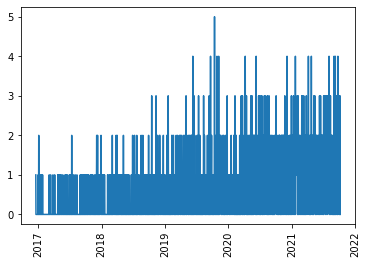

In [178]:
plt.plot(new_df.loc[new_df['product_id']==20552]['date'], new_df.loc[new_df['product_id']==20552]['sales_count'])
plt.xticks(rotation='vertical')

(array([16801., 17167., 17532., 17897., 18262., 18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

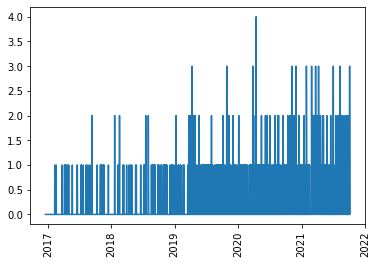

In [179]:
plt.plot(new_df.loc[new_df['product_id']==20547]['date'], new_df.loc[new_df['product_id']==20547]['sales_count'])
plt.xticks(rotation='vertical')

(array([16801., 17167., 17532., 17897., 18262., 18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

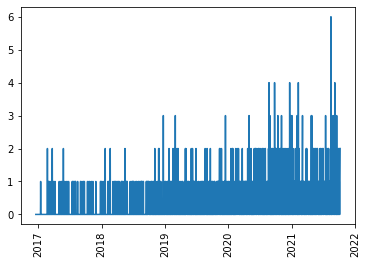

In [180]:
plt.plot(new_df.loc[new_df['product_id']==28305]['date'], new_df.loc[new_df['product_id']==28305]['sales_count'])
plt.xticks(rotation='vertical')

(array([16801., 17167., 17532., 17897., 18262., 18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

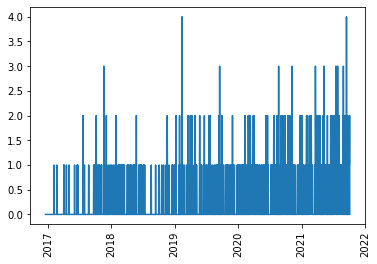

In [181]:
plt.plot(new_df.loc[new_df['product_id']==23641]['date'], new_df.loc[new_df['product_id']==23641]['sales_count'])
plt.xticks(rotation='vertical')

(array([16801., 17167., 17532., 17897., 18262., 18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

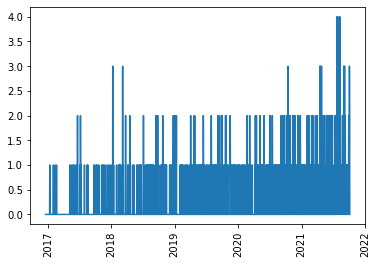

In [182]:
plt.plot(new_df.loc[new_df['product_id']==13596]['date'], new_df.loc[new_df['product_id']==13596]['sales_count'])
plt.xticks(rotation='vertical')

Checking data types for new_df dataframe

In [165]:
new_df.dtypes

date           datetime64[ns]
product_id              int64
sales_count              int8
dtype: object

Creating a big query table out of new_df dataframe

In [166]:
bq_client = bigquery.Client(project='vertex-ai-dev')

job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[
        bigquery.SchemaField("product_id", bigquery.enums.SqlTypeNames.INTEGER),
        bigquery.SchemaField("date", bigquery.enums.SqlTypeNames.DATE),
        bigquery.SchemaField("sales_count", bigquery.enums.SqlTypeNames.INTEGER),
    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    write_disposition="WRITE_TRUNCATE",
)

## save the dataframe to a table in the created dataset
job = bq_client.load_table_from_dataframe(
    new_df,
    "{}.{}.{}".format(PROJECT_ID, DATASET, SALES_TABLE),
    job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.


Creating training data by choosing starting and ending data

In [167]:
## select the date-range and item-id(top 5) for training-data and create a table for the same
TRAININGDATA_STARTDATE= '2016-12-17'
TRAININGDATA_ENDDATE= '2021-6-01'
query = """
CREATE OR REPLACE TABLE {DATASET}.training_data AS (
    
    SELECT 
        *
    FROM
        `{DATASET}.{SALES_TABLE}` 
    WHERE
        date BETWEEN '{STARTDATE}' AND '{ENDDATE}'
        
    );

""".format( STARTDATE=TRAININGDATA_STARTDATE,
            ENDDATE=TRAININGDATA_ENDDATE,
            DATASET= DATASET,
            SALES_TABLE= SALES_TABLE)
## execute the query (as it is a create query, there won't be any tabular output)
_ = bq_client.query(query)

Select the original data for plotting

In [169]:

df_historical = new_df[(new_df['date']>=pd.to_datetime(TRAININGDATA_STARTDATE))&
                              (new_df['date']<=pd.to_datetime(TRAININGDATA_ENDDATE))].copy()
df_historical

,date,product_id,sales_count
0,2016-12-17,20552,1
1,2016-12-18,20552,0
2,2016-12-19,20552,0
3,2016-12-20,20552,0
4,2016-12-21,20552,0
...,...,...,...
8643,2021-05-28,20547,0
8644,2021-05-29,20547,0
8645,2021-05-30,20547,0
8646,2021-05-31,20547,0


## Modeling with BigQuery and the ARIMA model
<a name="section-6"></a>


#@bigquery
CREATE OR REPLACE MODEL demandforecasting.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='sales_count',
  TIME_SERIES_ID_COL='product_id',
  HOLIDAY_REGION='US'
    
) AS

SELECT 
    date,
    product_id,
    sales_count
FROM
  demandforecasting.training_data

In [170]:
## Train an ARIMA model on the created dataset
query = """
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET}.arima_model`

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='sales_count',
  TIME_SERIES_ID_COL='product_id') AS

SELECT 
    date,
    product_id,
    sales_count
FROM
  `{PROJECT_ID}.{DATASET}.training_data`
""".format(PROJECT_ID=PROJECT_ID, DATASET= DATASET)
## execute the query
job = bq_client.query(query)
job.result()

# Evaluating the model
<a name="section-7"></a>


To evaluate the trained model, lets get forecasts for 90 days from the last date of the training-data. In BQML, we can provide the number of days of forecast we need using the "HORIZON" argument. Apart from number of days of forecast, we can also specify the confidence interval for the forecast by specifying "CONFIDENCE_LEVEL" argument.

#@bigquery dfforecast 

DECLARE HORIZON STRING DEFAULT "90";
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";

EXECUTE IMMEDIATE format('''
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL demandforecasting.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    ''',HORIZON,CONFIDENCE_LEVEL)

Load the data into a dataframe "dfforecast".

In [171]:
client = Client()

query = '''DECLARE HORIZON STRING DEFAULT "90"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90"; ## required confidence level

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL demandforecasting.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)'''
job = client.query(query)
dfforecast = job.to_dataframe()

In [172]:
dfforecast.head()

,product_id,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,13596,2021-06-02 00:00:00+00:00,0.453448,0.397189,0.9,-0.199162,1.106058,-0.199162,1.106058
1,13596,2021-06-03 00:00:00+00:00,0.430828,0.397545,0.9,-0.222366,1.084022,-0.222366,1.084022
2,13596,2021-06-04 00:00:00+00:00,0.414326,0.397737,0.9,-0.239184,1.067837,-0.239184,1.067837
3,13596,2021-06-05 00:00:00+00:00,0.379068,0.398587,0.9,-0.275839,1.033974,-0.275839,1.033974
4,13596,2021-06-06 00:00:00+00:00,0.375882,0.398596,0.9,-0.279040,1.030804,-0.279040,1.030804


In [173]:
print(f"Number of rows: {dfforecast.shape[0]}")

Number of rows: 450


Clean the historical and forecasted values for plotting


In [174]:
df_historical.sort_values(by=["product_id","date"], inplace=True)
dfforecast.sort_values(by=["product_id","forecast_timestamp"], inplace=True)

## Select the actual data to plot against the forecasted data
day_diff = (new_df['date'] - pd.to_datetime(TRAININGDATA_ENDDATE)).dt.days 
df_actual_90d = new_df[new_df['product_id'].isin(dfforecast['product_id'].unique())][(day_diff > 0 )&(day_diff <= 90)].copy()
df_actual_90d.shape

(450, 3)

Plot the historical and forecast data.


Product_id :  13596


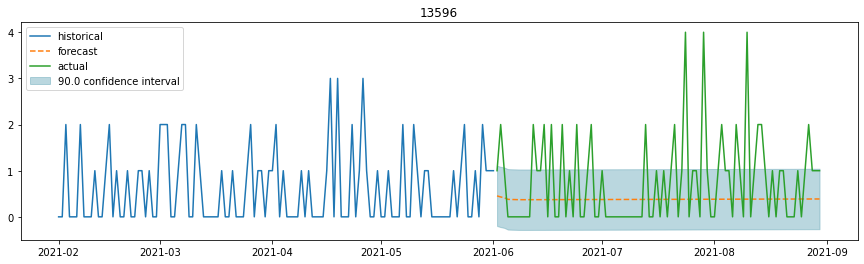

Product_id :  20547


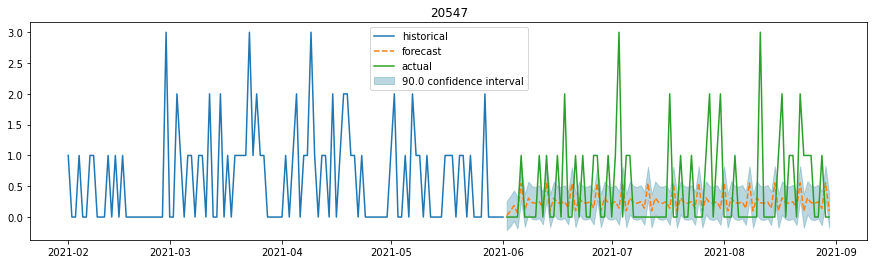

Product_id :  20552


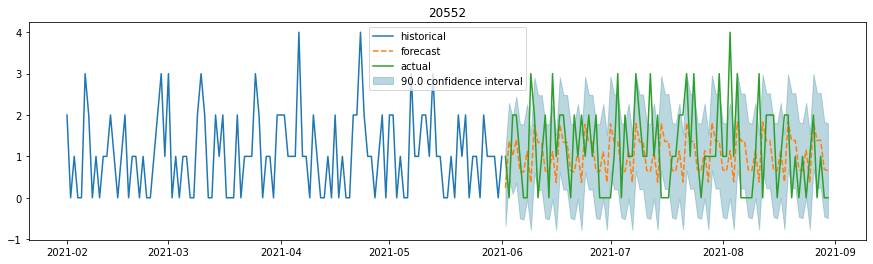

Product_id :  23641


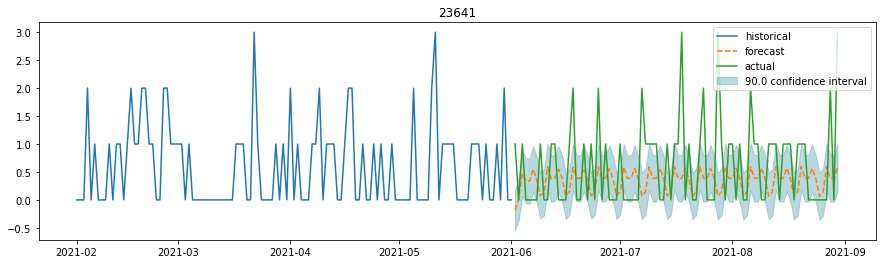

Product_id :  28305


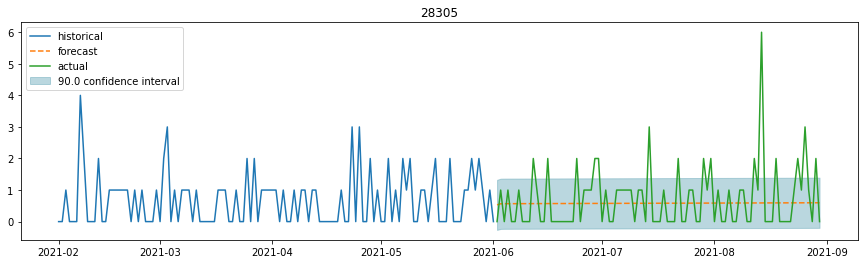

In [175]:
def plot_hist_forecast(historical, forecast, actual, hist_start="", hist_end="", title="") :
    if hist_start != "":
        historical = historical[historical["date"] >= pd.to_datetime(hist_start,format="%Y-%m-%d")].copy()
    if hist_end != "":
        historical = historical[historical["date"] <= pd.to_datetime(hist_end,format="%Y-%m-%d")].copy()
        
    plt.figure(figsize=(15,4))
    plt.plot(historical["date"], historical["sales_count"], label="historical")
    # Plot the forecast data
    plt.plot(forecast["forecast_timestamp"], forecast["forecast_value"], label="forecast", linestyle='--')
    # Plot the actual data
    plt.plot(actual["date"], actual["sales_count"], label="actual")
    ## plot the confidence interval
    confidence_level = forecast['confidence_level'].iloc[0] * 100
    low_CI = forecast['confidence_interval_lower_bound']
    upper_CI = forecast['confidence_interval_upper_bound']
    
    # Shade the confidence interval
    plt.fill_between(forecast["forecast_timestamp"], low_CI, upper_CI, color = '#539caf', alpha = 0.4, 
                     label = f'{confidence_level} confidence interval')
    plt.legend()
    plt.title(title)
    plt.show()
    return

product_id_list = dfforecast["product_id"].unique()
for i in item_id_list :
    print ("Product_id : ", i)
    plot_hist_forecast(df_historical[df_historical["product_id"] == i], 
                       dfforecast[dfforecast["product_id"]==i], 
                       df_actual_90d[df_actual_90d["product_id"]==i],
                       hist_start="2021-02-01", title=i)

While most of the predictions are looking decent, you can also see that the actual ranges fall into the 90% confidence interval suggested by the model. Under the hood, BQML performs many computationally expensive tasks even considering the seasonal and holiday information.
<img src="https://cloud.google.com/bigquery-ml/images/BQ_ARIMA_diagram.png"> <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series"> Source</a> </img>

The coefficients learned by BQML's ARIMA model can also be checked by simply querying for <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients">ARIMA_COEFFICIENTS</a> from the model.

#@bigquery
SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL demandforecasting.arima_model)

In the above results, 
- <b>product_id</b> column represents the index column we've specified while training the ARIMA model.
- <b>ar_coefficients</b> column corresponds to the autoregressive coefficients in the ARIMA algorithm(non-seasonal p).
- <b>ma_coefficients</b> refers to the moving average coefficients in the ARIMA algorithm(non-seasonal q).
- <b>intercept_or_drift</b> is the constant term in the ARIMA algorithm.

## Evaluating the model results using BQML 
<a name="section-7-subsection-1"></a>


Nevertheless, BQML also provies us with the <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate">ML.EVALUATE</a> function to see check the evaluation metrics of the trained model. For ARIMA model, we can see the model being evaluated on log_likelihood, AIC and variance measures. 

#@bigquery
SELECT
  *
FROM
  ML.EVALUATE(MODEL demandforecasting.arima_model)

## Evaluting the model results - MAE, MAPE, MSE, RMSE (on Test data)
<a name="section-7-subsection-2"></a>


Generally, to evaluate forecast model, we have various metrics depending on how we want to evaluate. For starters, we can choose from the following : 
* <b>Mean Absolute Error (MAE)</b> : Average of the absolute differences between the actual values and the forecasted values.
* <b>Mean Absolute Percentage Error (MAPE)</b> : Average of the percentages of absolute difference between the actual and forecasted values to the actual values.
* <b>Mean Squared Error (MSE)</b> : Average of squared differences between the actual and forecasted values.
* <b>Root Mean Squared Error (RMSE)</b> : Root of MSE

In [176]:

df_actual_90d.sort_values(by=["product_id","date"], inplace=True)
df_actual_90d.reset_index(drop=True, inplace=True)
dfforecast.sort_values(by=["product_id", "forecast_timestamp"], inplace=True)
dfforecast.reset_index(drop=True, inplace=True)

In [177]:
errors = {"product_id":[], "MAE":[], "MAPE":[], "MSE":[], "RMSE":[]}
for i in product_id_list :
    mae = mean_absolute_error(df_actual_90d[df_actual_90d["product_id"]==i]["sales_count"],
                             dfforecast[dfforecast["product_id"]==i]["forecast_value"])
    mape = mean_absolute_percentage_error(df_actual_90d[df_actual_90d["product_id"]==i]["sales_count"],
                             dfforecast[dfforecast["product_id"]==i]["forecast_value"])
    mse = mean_squared_error(df_actual_90d[df_actual_90d["product_id"]==i]["sales_count"],
                             dfforecast[dfforecast["product_id"]==i]["forecast_value"],squared=True)
    rmse = mean_squared_error(df_actual_90d[df_actual_90d["product_id"]==i]["sales_count"],
                             dfforecast[dfforecast["product_id"]==i]["forecast_value"],squared=False)
    errors["product_id"].append(i)
    errors["MAE"].append(mae)
    errors["MAPE"].append(mape)
    errors["MSE"].append(mse)
    errors["RMSE"].append(rmse)
errors = pd.DataFrame(errors)
errors

,product_id,MAE,MAPE,MSE,RMSE
0,13596,0.752581,8.505267e+14,1.033025,1.016379
1,20547,0.536853,7.270733e+14,0.581119,0.762312
2,20552,0.896490,1.397336e+15,1.190419,1.091063
3,23641,0.631763,8.404797e+14,0.668938,0.817886
4,28305,0.737716,1.394103e+15,0.954218,0.976841


From the values obtained for various error measures, you can identify that for product id's 20552, 13596 error measures are high. It has to be noted that these error measures are an aggregate of all the individual forecasts made during the test period and so we get an overall picture of the model's performance over the selected period. Ideally, the lower these error measures, the better the model is good at forecasting.

## Executor
<a name="section-8"></a>
From the navbar you see below select executor option


<img src="images/navbar_exe.png" ></img>


Give the execution name. Select the cloud storage bucket,machine type, accelerator type. For environment you can choose python 3 here from the environment options


<img src="images/exe_form.png" style="height:500px;width:500px"></img>


<img src="images/python3_env_selection.png" style="height:500px;width:500px"></img>


In type option you can select Schedule-based recurring executions if you want to schelule the execution like every 1 hour.

<img src="images/schedule.png" style="height:500px;"></img>


You can see the history of executions by selecting last but one item on the down from the side nav bar

<img src="images/side_nav.png" style="height:500px;"></img>


You can see history of executions here

<img src="images/list_execution.png" style="height:500px;width:500px"></img>


You can see history of schedules here

<img src="images/list_schedule.png" style="height:500px;width:500px"></img>


## Clean up
<a name="section-9"></a>


To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial(The following code deletes entire dataset).



In [ ]:
# Construct a BigQuery client object.
client = bigquery.Client()

# TODO(developer): Set model_id to the ID of the model to fetch.
dataset_id = 'your-project-id.dataset-name'

# Use the delete_contents parameter to delete a dataset and its contents.
# Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
client.delete_dataset(
    dataset_id, delete_contents=True, not_found_ok=True
)  # Make an API request.

print("Deleted dataset '{}'.".format(dataset_id))